# Sea level for current year

This notebook computes the preliminary mean sea level. This notebook is part of the validation of the official [sea-level monitor](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/dutch-sea-level-monitor.ipynb) for the Dutch coast. The official figures are not available until Rijkswaterstaat delivers data to the [PSMSL](http://www.psmsl.org) (often in june, and on request). Here we compute the mean for what is called the [metric](http://www.psmsl.org/data/obtaining/metric.php) data, that means uncorrected for changes in the tide gauge benchmark. The official sea-level rise figures use the [Revised Local Reference](http://www.psmsl.org/data/obtaining/rlr.php) figures. The information on the validation of previous years can be found in the [paired difference](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/validation/paired%20difference%20analysis%20RWS%20and%20PSMSL.ipynb) analysis. 

To run this notebook please download the data using the makefiles in data/psmsl and data/waterbase. The current sea-level rise depends on the official mean and on the wind data from the NCAR [NCEP](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html) reanalysis (available a few days after each month). The data for the last few years are compared to the PSMSL data. We use the metric data in this notebook as the RLR version is part of the validation for the final figures.

In [1]:
# builtin modules
import json
import logging
import datetime 
import io
import pathlib

# numeric 
import numpy as np
import pandas as pd
import netCDF4

# downloading data
import requests
#import ddlpy
#import ddlpy.ddlpy

# timezones
from dateutil.relativedelta import relativedelta
import pytz

# progress
from tqdm import tqdm_notebook as tqdm

# plotting
import matplotlib.dates 
import matplotlib.pyplot as plt
import IPython.display

# tide
import utide

import tqdm


# for interactive charts
from ipywidgets import interact

%matplotlib inline

# create a logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('notebook')


In [2]:
# For which year do we want to do the validation
current_year = 2019
start_date = datetime.datetime(current_year - 2, 1, 1)
end_date = datetime.datetime(current_year + 1, 1, 1)


# note that there are two stations for IJmuiden.
# The station was moved from the sluices to outside of the harbor in 1981.
# DDL id's
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'VLISSGN'] # PUT THIS BACK!!!!!!

# The id's with a name (BTNHVN is the current station)
names = {
    'DELFZL': 'Delfzijl',
    'DENHDR': 'Den Helder',
    'HARLGN': 'Harlingen',
    'HOEKVHLD': 'Hoek van Holland',
    'IJMDBTHVN': 'IJmuiden',
    'VLISSGN': 'Vlissingen'
}

# Names as used by waterinfo
names_waterinfo = ['Vlissingen', 'Hoek van Holland', 'IJmuiden Buitenhaven', 'Den Helder', 'Harlingen', 'Delfzijl']

# Names as used by matroos
names_matroos = [
    "vlissingen",
    "hoekvanholland",
    "ijmuiden",
    "denhelder",
    "harlingen",
    "delfzijl"
]

# ids from http://www.psmsl.org/data/obtaining/
psmsl_ids = {
    'DELFZL': 24, 
    'DENHDR': 23, 
    'HARLGN': 25, 
    'HOEKVHLD': 22,
    'IJMDBTHVN': 32, 
    'VLISSGN': 20
    
}
# metric data url 
psmsl_url = 'http://www.psmsl.org/data/obtaining/met.monthly.data/{}.metdata'


# fill in the format later
path = str(
    pathlib.Path('~/src/sealevel/data/waterbase/{station}-{year}.txt').expanduser()
)

# Some storm surges, used for context
storm_surge_reports = [
    {
        'date': datetime.datetime(2017, 1, 14),
        'url': 'https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen/download:782'
    },
    {
        'date': datetime.datetime(2017, 10, 29),
        'url': 'https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen/download:994'
    },
    {
        'date': datetime.datetime(2018, 1, 3),
        'url': 'https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen/download:1110'
    },
    {
        'date': datetime.datetime(2019, 1, 8),
        'url':'https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen/download:1460'
        
    }
]


In [3]:
psmsl_dfs = []
for name, id_ in psmsl_ids.items():
    url = psmsl_url.format(id_)
    resp = requests.get(url)
    psmsl_df = pd.read_csv(io.BytesIO(resp.content), sep=';', names=['year_frac', 'h', 'flag', 'code'])
    psmsl_df['station'] = name
    psmsl_dfs.append(psmsl_df)
psmsl_df = pd.concat(psmsl_dfs)
psmsl_df['year'] = np.floor(psmsl_df['year_frac'])
psmsl_df[psmsl_df['year'] > 2000].groupby(['station', 'year']).mean()

# mean values
mean_df = psmsl_df.groupby('year').mean()


In [4]:
mean_df.tail()

,year_frac,h,flag,code
year,,,,
2014.0,2014.5,66.152778,0.0,0.0
2015.0,2015.5,91.847222,0.0,0.0
2016.0,2016.5,77.694444,0.0,0.0
2017.0,2017.5,111.250000,0.0,0.0
2018.0,2018.5,38.222222,0.0,0.0


# DDL
These are the records from the Data Distributie Laag. We check them for the following:
* coverage
* gaps
* values (domain, jumps)


In [5]:
# Read the ddl 
#all_measurements = {}

#for id_ in ids:
#    year_measurements= []
#    for year in range(start_date.year, end_date.year):
#        # for now in a pickle format
#        #data_dir = pathlib.Path('~/src/sealevel/data/rws/ddl/raw/')

#        data_dir = pathlib.Path('../../data/ddl/raw/')
#        filename= "{}_WATHTE_NAP_{}.csv".format(id_, year)
        
#        #name = (data_dir / id_).with_suffix('.pck')
#        measurements_1year = pd.read_csv(data_dir / filename, parse_dates= ['t']) #pd.read_pickle(name)
#        # date in original data messy
#        measurements_1year = measurements_1year.sort_values(by= ['t']).reset_index().drop('index', axis=1) #new line
#        measurements_1year['station'] = id_
#        year_measurements.append(measurements_1year)
#    measurements = pd.concat(year_measurements, ignore_index= True)
#    all_measurements[id_] = measurements
    
#all_df = pd.concat(all_measurements)
## group per station
#grouped = all_df.groupby('station') #### Not necesary as all_df already is grouped


In [14]:
# Read the ddl 
all_measurements = {}

for id_ in ids:
    data_dir = pathlib.Path('../../data/ddl/raw/')
    filename= "{}_OW_cm_WATHTE_NAP_NVT.csv".format(id_)
    measurements = pd.read_csv(data_dir / filename, parse_dates= ['t']) #pd.read_pickle(name)
    # date in original data messy
    measurements = measurements.sort_values(by= ['t']).reset_index().drop('index', axis=1) #new line
    if ('Unnamed: 0' in measurements.columns):
        measurements.drop('Unnamed: 0', axis=1, inplace= True)
    measurements['station'] = id_
    all_measurements[id_] = measurements
    
all_df = pd.concat(all_measurements) # concat on dictionary
# group per station
grouped = all_df.groupby('station') #### Not necesary as all_df already is grouped

In [15]:
# We need to organize the data b the quality (WaarnemingMetadata.StatuswaardeLijst):
# Gecontroleerd or Ongecontroleerd, to remove duplicated values (keepeing the first record: the Gecontroleerd one)
for id_ in ids:
    all_measurements[id_].sort_values(by= ['t', 'WaarnemingMetadata.StatuswaardeLijst'], inplace= True)

In [19]:
# check for duplicates
all_measurements['DELFZL'][['WaarnemingMetadata.StatuswaardeLijst', 't', 'Meetwaarde.Waarde_Numeriek']].head()

,WaarnemingMetadata.StatuswaardeLijst,t,Meetwaarde.Waarde_Numeriek
1,Gecontroleerd,2017-01-01 00:00:00,164.0
0,Ongecontroleerd,2017-01-01 00:00:00,165.0
2,Ongecontroleerd,2017-01-01 00:01:00,165.0
3,Ongecontroleerd,2017-01-01 00:02:00,165.0
4,Ongecontroleerd,2017-01-01 00:03:00,165.0


# Duplicated timestamps per station
Remove duplicates in time and water level, but report duplicates in time with different water level

In [21]:
# checks that we have controlled or uncontrolled data before removing the duplicates.
# To do: Put something better than assert, since it gave an error without message.
for station in ids:
    print(station, all_measurements[station].shape)
    #assert set(all_measurements[station][ 'WaarnemingMetadata.StatuswaardeLijst'])==  {'Ongecontroleerd', 'Gecontroleerd'}
    dup_df = all_measurements[station].drop_duplicates(subset=['t', 'Naam'], keep= 'first') 
    all_measurements[station] = dup_df
    print(station, all_measurements[station].shape) 
    #print(d1.shape[0])
    

DELFZL (1685522, 51)
DELFZL (1570397, 51)
DENHDR (1527162, 51)
DENHDR (1419771, 51)
HARLGN (1688238, 51)
HARLGN (1568798, 51)
HOEKVHLD (1689353, 51)
HOEKVHLD (1557610, 51)
IJMDBTHVN (157659, 51)
IJMDBTHVN (157659, 51)
VLISSGN (1700646, 51)
VLISSGN (1570081, 51)


In [22]:
# Drop missing dates or missing water levels
for station in ids:
    print(station, all_measurements[station].shape )
    all_measurements[station] = all_measurements[station].dropna(how= 'any', subset= ['t', 'Meetwaarde.Waarde_Numeriek'])
    print(station, all_measurements[station].shape )

DELFZL (1570397, 51)
DELFZL (1570396, 51)
DENHDR (1419771, 51)
DENHDR (1419770, 51)
HARLGN (1568798, 51)
HARLGN (1568797, 51)
HOEKVHLD (1557610, 51)
HOEKVHLD (1557609, 51)
IJMDBTHVN (157659, 51)
IJMDBTHVN (157658, 51)
VLISSGN (1570081, 51)
VLISSGN (1570080, 51)


# Coverage check per station
Check begin and end time and number of measurements

In [23]:
#Check initial and end date per station in all_measurements.
for id_ in ids:
    print(id_, all_measurements[id_]['t'].values[0], all_measurements[id_]['t'].values[-1] )

DELFZL 2017-01-01T00:00:00.000000000 2020-01-01T00:00:00.000000000
DENHDR 2017-01-01T00:00:00.000000000 2020-01-01T00:00:00.000000000
HARLGN 2017-01-01T00:00:00.000000000 2020-01-01T00:00:00.000000000
HOEKVHLD 2017-01-01T00:00:00.000000000 2020-01-01T00:00:00.000000000
IJMDBTHVN 2017-01-01T00:00:00.000000000 2020-01-01T00:00:00.000000000
VLISSGN 2017-01-01T00:00:00.000000000 2020-01-01T00:00:00.000000000


In [24]:
# Fedor's original test.
# The number of records should be the same!!!! 
# For 2019: last measurement should be 2019-12-31 : 23:... Not 2020-01-01, so remove last observation per station
for station, group_df in grouped:
    group_df = group_df.set_index('t')
    print('station', station)
    print(group_df.index.min(), group_df.index.max(), group_df.shape[0])
    

station DELFZL
2017-01-01 00:00:00 2020-01-01 00:00:00 1685522
station DENHDR
2017-01-01 00:00:00 2020-01-01 00:00:00 1527162
station HARLGN
2017-01-01 00:00:00 2020-01-01 00:00:00 1688238
station HOEKVHLD
2017-01-01 00:00:00 2020-01-01 00:00:00 1689353
station IJMDBTHVN
2017-01-01 00:00:00 2020-01-01 00:00:00 157659
station VLISSGN
2017-01-01 00:00:00 2020-01-01 00:00:00 1700646


In [35]:
# Remove last observation 
for station in ids:
    all_measurements[station]= all_measurements[station].iloc[0:-1, :]
    
all_df = pd.concat(all_measurements) # concat on dictionary
# group per station
grouped = all_df.groupby('station')

In [36]:
# check if there are gaps of more than 1200 seconds
for station, group_df in grouped:   
    diff_t = np.diff(np.asarray(group_df['t'], 'datetime64[s]')).astype('timedelta64[s]') /  np.timedelta64(1, 's')
    gaps, = np.where(diff_t > 1200)
    for i, gap in enumerate(gaps):
        #print(station, group_df.iloc[gap], gap) # original line
        #print(station, gap, group_df['t'][gap])
        print(station, gap, group_df.iloc[gap].t, diff_t[gap])
        if i > 100:
            print('100 gaps reported, stopping')
            break 


DENHDR 1015249 2019-01-02 00:20:00 1800.0
DENHDR 1018470 2019-01-24 11:20:00 1800.0
DENHDR 1018987 2019-01-28 02:00:00 1800.0
DENHDR 1020669 2019-02-08 20:10:00 1800.0
DENHDR 1022410 2019-02-20 23:40:00 1800.0
DENHDR 1207365 2019-07-05 13:00:00 4200.0
DENHDR 1207373 2019-07-05 15:50:00 6600.0
DENHDR 1208399 2019-07-10 22:10:00 6000.0
DENHDR 1208487 2019-07-11 14:30:00 2400.0
DENHDR 1208826 2019-07-14 00:00:00 1800.0
DENHDR 1209321 2019-07-17 11:20:00 3000.0
DENHDR 1209325 2019-07-17 12:40:00 1800.0
DENHDR 1209326 2019-07-17 13:10:00 18000.0
DENHDR 1209405 2019-07-18 07:10:00 15600.0
DENHDR 1209553 2019-07-19 12:10:00 6600.0
DENHDR 1209555 2019-07-19 14:10:00 1800.0
DENHDR 1209835 2019-07-21 13:20:00 2400.0
DENHDR 1209836 2019-07-21 14:00:00 1800.0
DENHDR 1209840 2019-07-21 15:20:00 7800.0
DENHDR 1209841 2019-07-21 17:30:00 1800.0
DENHDR 1209965 2019-07-22 14:30:00 9000.0
DENHDR 1209966 2019-07-22 17:00:00 3000.0
DENHDR 1209967 2019-07-22 17:50:00 1800.0
DENHDR 1210054 2019-07-23 08:50:

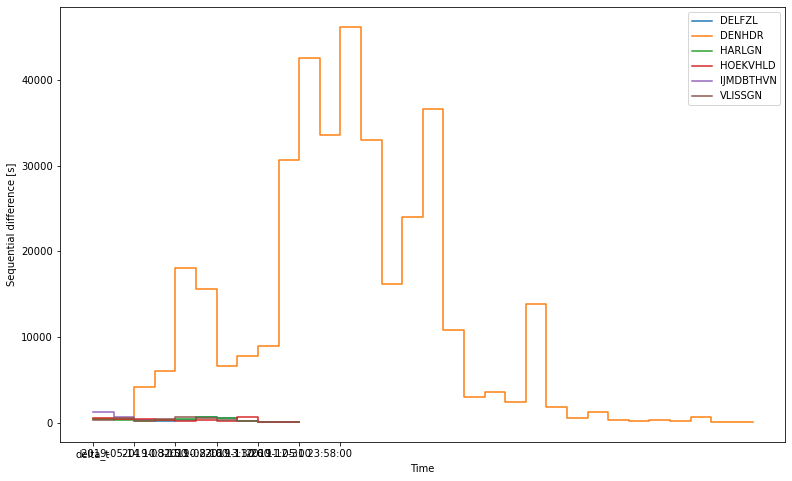

In [37]:
# TODO: cleanup this visualization (only show changes in delta_t) -> Plot Dt vs. Time
# Time plotting is a bit messy when switching between pandas and numpy 
# Point is: it should be a line, it is not. So we need to resample per station before taking the annual average

fig, ax = plt.subplots(figsize=(13, 8))
for i, (station, group_df) in enumerate(grouped):
    t = np.asarray(group_df['t'], 'datetime64[s]')
    # compute delta_t per measurement in 
    diff_t = np.diff(t) /  np.timedelta64(1, 's')
    series = pd.DataFrame(index=t[:-1], data=dict(delta_t=diff_t))
    first = series.iloc[0]
    last = series.iloc[-1]
    series = series.drop_duplicates(subset='delta_t', keep='last')
    series = pd.concat([first, series, last])
    
    (series.delta_t + (i * 1)).plot(drawstyle="steps", ax=ax)
    
ax.set_ylabel('Sequential difference [s]')
ax.set_xlabel('Time')
ax.legend([x[0] for x in grouped], loc='best')

In [39]:
# Compute the means per station and take the means over time
all_ddl_means = {}
for id_, measurements in all_measurements.items():
    # first resample by day and then by year to correct for the varying sample frequency across the year
    means = measurements.set_index('t').resample('D').mean().resample('YS').mean()
    # bug in pandas (remove in 0.24)
    # https://github.com/pandas-dev/pandas/pull/22488 
    #means.index = means.index + pd.Timedelta(days=1)
    all_ddl_means[id_] = means


In [40]:
# Compute the means over the stations
pd.concat(all_ddl_means.values()).reset_index().groupby('t').agg('mean')[['Meetwaarde.Waarde_Numeriek']]

,Meetwaarde.Waarde_Numeriek
t,
2017-01-01,11.236490
2018-01-01,3.863277
2019-01-01,10.908250


In [41]:
# Read all the matroos data (operational forecasting data)
import netCDF4
import matplotlib.pyplot as plt

surge_dfs = []
model_dfs = []
observed_dfs = []
for station in names_matroos:
    #surge_path = pathlib.Path('~/src/sealevel/data/rws/matroos/{}_surge_forecast.nc'.format(station)).expanduser()
    #model_path = pathlib.Path('~/src/sealevel/data/rws/matroos/{}_waterlevel_forecast.nc'.format(station)).expanduser()
    #observed_path = pathlib.Path('~/src/sealevel/data/rws/matroos/{}_waterlevel_observed.nc'.format(station)).expanduser()
    surge_path = pathlib.Path('../../data/rws/matroos/{}_surge_forecast.nc'.format(station)).expanduser()
    model_path = pathlib.Path('../../data/rws/matroos/{}_waterlevel_forecast.nc'.format(station)).expanduser()
    observed_path = pathlib.Path('../../data/rws/matroos/{}_waterlevel_observed.nc'.format(station)).expanduser()
    with netCDF4.Dataset(surge_path) as ds:
        t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units,only_use_cftime_datetimes= False)
        h = np.squeeze(ds.variables['waterlevel_surge'][:])
        surge_df = pd.DataFrame(data=dict(t=t, h=h))
        surge_df['station'] = station
        surge_dfs.append(surge_df)
        

    with netCDF4.Dataset(model_path) as ds:
        t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units, only_use_cftime_datetimes= False )
        h = np.squeeze(ds.variables['waterlevel'][:])
        model_df = pd.DataFrame(data=dict(t=t, h=h))
        model_df['station'] = station
        model_dfs.append(model_df)

    with netCDF4.Dataset(observed_path) as ds:
        t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units, only_use_cftime_datetimes= False)
        h = np.squeeze(ds.variables['waterlevel'][:])
        observed_df = pd.DataFrame(data=dict(t=t, h=h))
        observed_df['station'] = station
        observed_dfs.append(observed_df)
        
surge_df = pd.concat(surge_dfs)        
model_df = pd.concat(model_dfs)
observed_df = pd.concat(observed_dfs)


C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:16: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  app.launch_new_instance()
C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


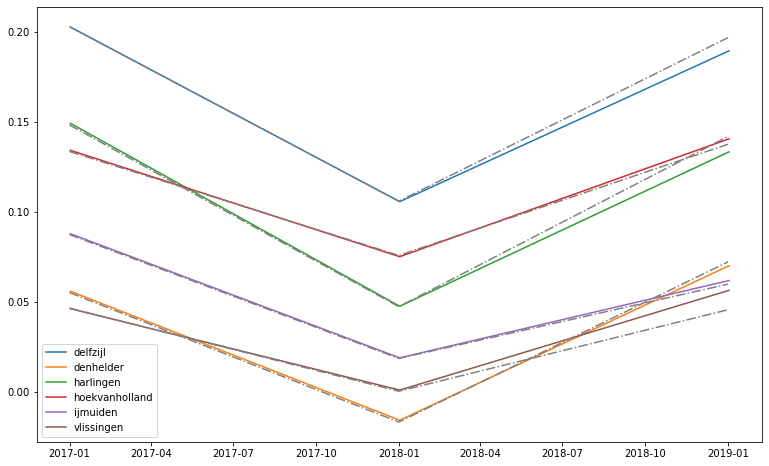

In [42]:
# Plot Matroos data and DDL data together. 
# Should be nearly simmilar (after double resamping because of the time varying measurement frequency)
grouped = observed_df[observed_df['t'] < datetime.datetime(2020, 1, 1)].groupby('station')


fig, ax = plt.subplots(figsize=(13, 8))
# compute to annual means per station because measurement frequencies are not equal between stations
all_matroos_means = {}
for id_, group_df in grouped:
    matroos_means = group_df.set_index('t').resample('D').mean().resample('YS').mean()
    # bug in pandas (remove in 0.24)
    # https://github.com/pandas-dev/pandas/pull/22488 
    matroos_means.index = matroos_means.index + pd.Timedelta(days=1)
    ax.plot(matroos_means.index, matroos_means['h'], label=id_)
    all_matroos_means[id_] = matroos_means
    
for id_, means in all_ddl_means.items():
    ax.plot(means.index, means['Meetwaarde.Waarde_Numeriek'] / 100, '-.', label='', color='grey')
_ = ax.legend(loc='best')

In [43]:
# Compute the mean again (double check left/right indexing of the aggregation timestamp)
pd.concat(all_ddl_means).reset_index().groupby('t').agg('mean')['Meetwaarde.Waarde_Numeriek']

t
2017-01-01    11.236490
2018-01-01     3.863277
2019-01-01    10.908250
Name: Meetwaarde.Waarde_Numeriek, dtype: float64

Text(0, 0.5, 'sea surface height (unvalidated)\n[mm relative to NAP]')

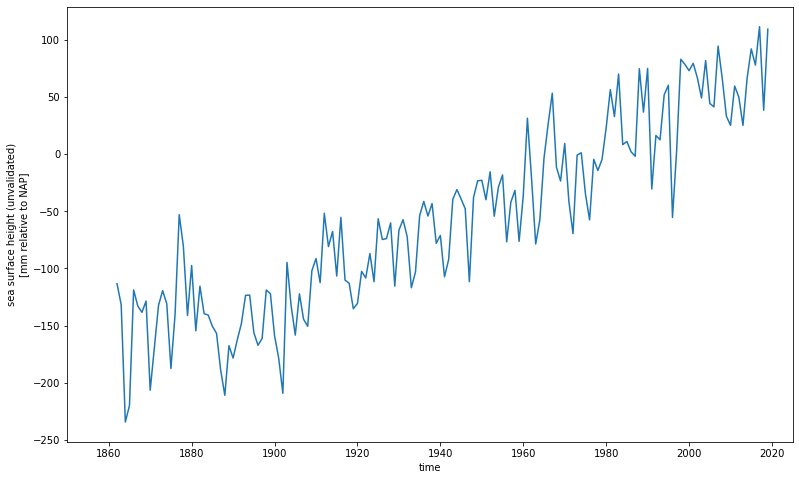

In [45]:
# Manually copy the new average to the series
# This are the figures that we use to provide the preliminary sea-level figures
fig, ax = plt.subplots(figsize=(13, 8))
new_row = pd.DataFrame(
    [
        pd.Series(
            name= current_year, 
            data=dict(h=10.9082*10)
        )
    ]
)
final_df = pd.concat([mean_df, new_row], sort=True)
final_df.tail()
final_df['h'].plot(ax=ax)
ax.set_xlim(1850, 2025)
ax.set_xlabel('time')
ax.set_ylabel('sea surface height (unvalidated)\n[mm relative to NAP]')

In [46]:
# Look for noticable changes

# Top drops
print('Top drops')
IPython.display.display(final_df['h'].diff().sort_values().head(n=5))
print('Top rises')
IPython.display.display(final_df['h'].diff().sort_values(ascending=False).head(n=5))


Top drops


1996.0   -115.513889
1991.0   -105.333333
1864.0   -102.500000
1870.0    -77.833333
2018.0    -73.027778
Name: h, dtype: float64

Top rises


1903.0    114.361111
1866.0    100.916667
1877.0     87.152778
1998.0     79.888889
1988.0     76.527778
Name: h, dtype: float64

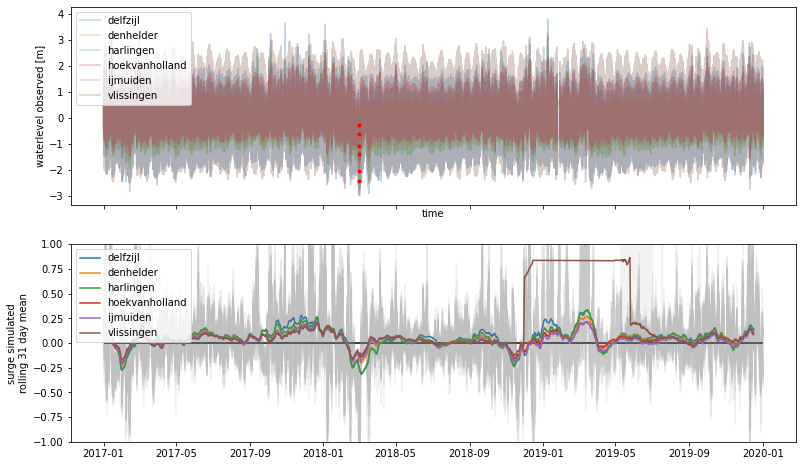

In [47]:
# this figure shows the time varying surge component
# this can be used to look at origins (often storms) of the changes
fig, axes = plt.subplots(nrows=2, figsize=(13, 8), sharex=True)

for station, df in observed_df.groupby('station'):
    axes[0].plot(df['t'], df['h'], alpha=0.3, label=station)

mean_surge_df = surge_df.set_index('t').resample('D').mean()

surge_grouped = surge_df.groupby('station')
for station, df in surge_grouped:
    axes[1].plot(df['t'], df['h'], alpha=0.1, color='grey', label='')
    axes[1].plot(df['t'], df['h'].rolling(4500, center=True).mean(), label=station)

axes[1].set_ylim(-1, 1)
axes[1].hlines(0, t[0], t[-1])


# axes[0].plot()
# ax.set_xlim(datetime.datetime(2018, 11, 15), datetime.datetime(2019, 1, 1))
idx = surge_df.h.idxmin()
axes[0].plot([observed_df['t'].loc[idx]], [observed_df['h'].loc[idx]], 'r.')
axes[0].set_ylabel('waterlevel observed [m]')
axes[1].set_ylabel('surge simulated\nrolling 31 day mean')
axes[0].set_xlabel('time')
axes[0].legend()
_ = axes[1].legend(loc='upper left')

## Stations
You can change the year below and confirm the id's of the stations. These stations are considered the "main stations". They all have a long running history (>100 years) and are spread out somewhat evenly along the Dutch coast. For details of each tide gauge, please consult the [tide gauge overview](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/dutch-tide-gauges.ipynb). 


Here we read all the files, downloaded from [waterbase](http://live.waterbase.nl), the old source from Rijkswaterstaat, connected to DONAR. The official source ([Data Distributie Laag](https://www.rijkswaterstaat.nl/rws/opendata/DistributielaagWebservices-SUM-2v7.pdf)) is not functioning properly as data is missing since june last year (sent issue to servicedesk data). 
Here we only do a missing and value domain check. Quality flags are not available in the waterbase export and a detailed analysis of trend breaks, consistency between measurements is done in the official validation. 

### Note 27-05-2020 
The data from Den Helder is missing and some in Ijmuiden. Therefore, we can not proceed with the analysis of the tide and those that are listed below. Once the data is complete, we will run the complete analysis, in September

In [48]:
# create a list of records
records = []
# for each station
for station in ids:
    # look back a few years for consistency (from-through)
    for year in range(current_year-2, current_year + 1):
        df = pd.read_csv(path.format(station=station, year=year), skiprows=3, sep=';')
        # there should be no missings
        assert df['waarde'].isna().sum() == 0
        # all values should be within this range
        # if not check what's happening
        assert df['waarde'].min() > -400
        assert df['waarde'].max() < 600
        # and check the units
        assert (df['eenheid'] == 'cm').all()

        mean = df['waarde'].mean()
        records.append({
            'station': station,
            'year': year,
            'mean': mean
        })
        


FileNotFoundError: [Errno 2] File C:\Users\marti_cn\src\sealevel\data\waterbase\DELFZL-2017.txt does not exist: 'C:\\Users\\marti_cn\\src\\sealevel\\data\\waterbase\\DELFZL-2017.txt'

## Compare stations
Don't expect that all stations have the same mean sea level. Delfzijl [traditionaly](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/dutch-sea-level-monitor.ipynb#Regional-variability) has the highest mean sea-level, followed by Harlingen. Hoek van Holland has been rising for several years, due to local subsidence. Den Helder and Vlissingen traditionaly have the lowest sea-level. 

In [ ]:
# merge all the records to get a list of mean sea level per year
latest_df = pd.DataFrame(records)
# check the mean for 2017
latest_df.set_index(['station', 'year']) 

## Detailed analysis

Here we look at the timeseries in Detail to make sure that there are no outliers. All data is already gap-filled and checked for outliers in the validation steps before data is entered into DONAR. 
Things to check for: 
- make sure that the highest values correspond to known storms
- check for monthly signal [spring/neap](https://oceanservice.noaa.gov/facts/springtide.html) cycle (twice per month) 
- consistent signal


In [ ]:
# read the latest data 
sources = {}
for station in ids:
    df = pd.read_csv(path.format(station=station, year=current_year), skiprows=3, sep=';')
    df['date'] = pd.to_datetime(df['datum'] + ' ' + df['tijd'])
    # Several stations contain duplicates, drop them and keep the first
    # Not sure why.... (contact RWS)
    df = df.drop_duplicates(keep='first')
    # there should be no missings
    assert df['waarde'].isna().sum() == 0
    # all values should be within this range
    # if not check what's happening
    assert df['waarde'].min() > -400
    assert df['waarde'].max() < 600
    # and check the units
    assert (df['eenheid'] == 'cm').all()
    sources[station] = df



In [ ]:
# this is the data, a bit verbose but the relevant things are datum tijd and waarde
df = sources[ids[0]].set_index('date')
# make sure the dataset is complete until (almost) end of the year
df.tail()

# Tide
Here we seperate the tide. The official tidal computation is based on HATYAN, but that is not publicly available. So here we use the python version of [UTide](http://www.po.gso.uri.edu/~codiga/utide/utide.htm). This is just a basic ordinary least squares decomposition using an automated selection of constituents. In general the handpicked selection has a higher external validaty (predicts better). Our main concern here to seperate storm-surge and tide. 

In [ ]:
tides = {}
coefs = {}
for station, df in sources.items():
    # use date as an index (so we have a datetime index)
    df = df.set_index('date')
    t = matplotlib.dates.date2num(df.index.to_pydatetime())
    coef = utide.solve(
        t, 
        df['waarde'].values, # numpy array
        lat=52, # for the equilibrium nodal tide
        method='ols', # just use linear model
        conf_int='linear'
    )
    coefs[station] = coef
    tide = utide.reconstruct(t, coef)
    tides[station] = tide
    

In [ ]:
for station, df in sources.items():
    tide = tides[station]
    # update dataframe (inline)   
    df['tide'] = tide['h']
    df['surge'] = df['waarde'] - df['tide']

## Maximum water levels
We can now compute the maximum water levels for each station. This is most likely to occur during the combination of high tide and a storm surge.
You can often find some detailed information about an event using the [storm reports](https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen) of the SVSD. 
You can lookup the return periods using the [coastal forcings](https://www.helpdeskwater.nl/publish/pages/132669/1230087-002-hye-0001-v4-r-hydraulische_belastingen_kust_def3.pdf) document from WBI. 

In [ ]:
# compute the maximum water levels
records = []
for station, df in sources.items():
    date_df = df.set_index('date')
    
    max_date = date_df['waarde'].idxmax()
    record = {
        'station': station, 
        'date': max_date, 
        'value': date_df['waarde'].loc[max_date]
    }
    records.append(record)
annual_maxima_df = pd.DataFrame(records)
annual_maxima_df

# Maximum surge
We can also compute the maximum surge levels for each station. The surge is the water level minus the astronomical tide. These dates will be different from the table above because a high water level is more likely to occur during high tide.


In [ ]:
# compute the maximum surge
records = []
for station, df in sources.items():
    df = df.drop_duplicates(['date'])
    date_df = df.set_index('date')
    
    max_date = date_df['surge'].idxmax()
    record = {
        'station': station, 
        'date': max_date, 
        'surge': date_df['surge'].loc[max_date]
    }
    records.append(record)
annual_maxima_surge_df = pd.DataFrame(records)
annual_maxima_surge_df



In [ ]:
fig, axes = plt.subplots(
    # 2 rows, 1 column
    3, 1, 
    # big
    figsize=(18, 16), 
    # focus on tide
    gridspec_kw=dict(height_ratios=[3, 1, 1]),
    sharex=True
)
for station, df in sources.items():
    index = df.set_index('date').index
    axes[0].plot(index.to_pydatetime(), df['waarde'], '-', label=names[station], linewidth=0.2)
    axes[1].plot(index.to_pydatetime(), df['tide'], '-', label=station, alpha=0.5, linewidth=0.3)
    axes[2].plot(index.to_pydatetime(), df['surge'], '-', label=station, alpha=0.5, linewidth=0.3)
axes[0].legend(loc='best');
axes[0].set_ylabel('water level [cm]')
axes[1].set_ylabel('astronomical tide [cm]')
axes[2].set_ylabel('surge [cm]')
for event in storm_surge_reports:
    axes[2].fill_between(
        [event['date'] + datetime.timedelta(hours=-48), event['date'] + datetime.timedelta(hours=48)],
        y1=axes[1].get_ylim()[0],
        y2=axes[1].get_ylim()[1],
        alpha=0.1,
        facecolor='black'
    )

## Detailed view
Use the interactive plot below to look at the timeseries in detail. You can drag to have a look at each week. 
It is normal to see some high frequency patterns and to see some tidal residu. 

In [ ]:
# plot a window of a week

def plot(weeks=(0, 51)):
    
    fig, axes = plt.subplots(
        # 2 rows, 1 column
        3, 1, 
        # big
        figsize=(12, 8), 
        # focus on tide
        gridspec_kw=dict(height_ratios=[3, 1, 1]),
        sharex=True
    )
    for station, df in sources.items():
        selected = df[
            np.logical_and(
                df['date'] >= datetime.datetime(2017, 1, 1) + datetime.timedelta(weeks=weeks),
                df['date'] < datetime.datetime(2017, 1, 1) + datetime.timedelta(weeks=weeks + 1)
            )
        ]
        index = selected.set_index('date').index
        axes[0].plot(index.to_pydatetime(), selected['waarde'], '-', label=names[station], alpha=0.5, linewidth=2)
        axes[1].plot(index.to_pydatetime(), selected['tide'], '-', label=station, alpha=0.5, linewidth=2)
        axes[2].plot(index.to_pydatetime(), selected['surge'], '-', label=station, alpha=0.5, linewidth=2)
    axes[0].legend(loc='best');
    axes[0].set_ylabel('water level [cm]')
    axes[1].set_ylabel('astronomical tide [cm]')
    axes[2].set_ylabel('surge [cm]')
    axes[0].set_ylim(-300, 500)
    axes[1].set_ylim(-250, 250)
    axes[2].set_ylim(-100, 300)

interact(plot);

## Integration with PSMSL
Check the latest data with that of the PSMSL. There are some known differences because the data delivered to PSMSL is based on hourly data. Here we analyse the data of every minute. In general they should be within about a cm difference.


In [ ]:
# now get the PSMSL data for comparison
psmsls = {}

# TODO: read the zip file
for station, id_ in psmsl_ids.items():
    df = pd.read_csv(io.StringIO(requests.get('http://www.psmsl.org/data/obtaining/met.monthly.data/{}.metdata'.format(
        id_
    )).text), sep=';', names=[
        'year', 'level', 'code', 'quality'
    ])
    df['year'] = df.year.apply(lambda x: np.floor(x).astype('int'))
    df['station'] = station
    psmsls[station] = df
psmsl_df = pd.concat(psmsls.values())
# compute sea level in cm
psmsl_df['sea_level'] = psmsl_df['level'] / 10

In [ ]:
# compare data to metric data
# some differences exist
# see HKV report from 2017 on this topic 
# most differences are due to that I think hourly measurements are used for the psmsl mean
for station, df in psmsls.items():
    print(station)
    annual_df = df[['year', 'level']].groupby('year').mean()
    print(annual_df.tail(n=5))
    new_records = latest_df[np.logical_and(
        latest_df.station == station, 
        np.isin(latest_df.year, (2015, 2016, 2017))
    )]
    print(new_records)
    

In [ ]:
# mean sealevel from psmsl
mean_df = psmsl_df[['year', 'sea_level']].groupby('year').mean()

In [ ]:
mean_df.loc[current_year] = latest_df[latest_df['year'] == current_year]['mean'].mean()


## Top 10
This shows the highest annual mean sea levels since we started measuring. One would expect every year to be higher than the previous, but not all years have storm surges (for example, no storm surges from 2009 and through 2012). 
And the nodal tide also makes it more likely that high annual means occur during higher nodal tide. 


In [ ]:
# show the top 10 of highest sea levels
mean_df.sort_values('sea_level', ascending=False).head(n=10)

## Nodal tide
The nodal tide causes a variation with an amplitude of about 1cm. This makes it more likely that higher means occur during the upper cycle. The analysis below shows in which part of the cycle we are.


In [ ]:
# Use the fitted values from the sea-level monitor (note that these are RLR not in NAP)
years = mean_df.index[mean_df.index > 1890]
# use the model without wind (otherwise the intercept does not match up)
fitted = (
    1.9164 * (years - 1970)  + 
    -25.7566  +
    7.7983 * np.cos(2*np.pi*(years-1970)/18.613) +
    -10.5326 * np.sin(2*np.pi*(years-1970)/18.613)  
)


In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(mean_df.index, mean_df['sea_level'])
ax.plot(years, fitted/10)
ax.set_ylabel('sea-surface height (w.r.t. NAP/RLR) in cm')
ax.set_xlabel('time [year]');


In [ ]:
# find the maximum sea-level
mean_df.idxmax()

In [ ]:
# check the current phase of nodal tide, u,v from sea-level monitor (full model)
tau = np.pi * 2
t = np.linspace(current_year - 18, current_year + 18, num=100)
nodal_tide = 7.5367*np.cos(tau*(t - 1970)/18.6) + -10.3536*np.sin(tau*(t - 1970)/18.6) 
amplitude = np.sqrt(7.5367**2 + (-10.3536)**2)

fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(t, nodal_tide/10);
ax.set_ylabel('nodal tide [cm]')
ax.fill_between([2017, 2018], *ax.get_ylim(), alpha=0.2)
ax.grid('on')


In [ ]:
# next peak of nodal tide
2004.5 + 18.6